In [71]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np   
import itertools

from scipy.stats import chi2_contingency, ttest_ind
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
#import ace_tools as tools
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier

In [73]:
df = pd.read_parquet("output_08.parquet") #dataset con columnas innecesarias eliminadas

In [75]:
df.head()


,age,employment_stat,wage_per_hour,working_week_per_year,occupation_code,total_employed,gains,losses,stocks_status,gender_1.0,...,tax_status_Single,citizenship_Native,citizenship_Otro,country_of_birth_own_US,migration_code_change_in_msa_MSA to MSA,migration_code_change_in_msa_Otro,migration_code_change_in_msa_unchanged,migration_code_change_in_reg_Otro,migration_code_change_in_reg_unchanged,income_above_limit_1.0
0,0.853333,0.0,0.000000,1.000000,0.000000,0.333333,0.0,0.0,0.00292,True,...,False,True,False,True,False,False,False,False,False,False
1,0.666667,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,True,...,True,True,False,True,False,False,True,False,True,False
2,0.080000,0.0,0.050005,0.288462,0.565217,0.666667,0.0,0.0,0.00000,False,...,True,True,False,True,False,False,True,False,True,False
4,0.733333,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,False,...,False,True,False,True,False,False,False,False,False,False
5,0.400000,0.0,0.082508,1.000000,0.673913,1.000000,0.0,0.0,0.00000,False,...,False,False,False,False,False,False,True,False,True,False


In [77]:
df.columns

Index(['age', 'employment_stat', 'wage_per_hour', 'working_week_per_year',
       'occupation_code', 'total_employed', 'gains', 'losses', 'stocks_status',
       'gender_1.0', 'education_secondary_complete',
       'education_secondary_incomplete',
       'education_technical_education/university_incomplete',
       'education_university_graduate_or_higher',
       'marital_status_Married-civilian spouse present',
       'marital_status_Never married', 'marital_status_Otro',
       'marital_status_Widowed', 'race_Otro', 'race_White', 'is_hispanic_Otro',
       'employment_commitment_Full-time schedules',
       'employment_commitment_Not in labor force',
       'employment_commitment_Otro',
       'industry_code_main_Manufacturing-durable goods',
       'industry_code_main_Not in universe or children',
       'industry_code_main_Otro', 'industry_code_main_Retail trade',
       'household_stat_Householder', 'household_stat_Nonfamily Householder',
       'household_stat_Other', 'househol

In [79]:
#Arboles de decisión normal

In [89]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Separar variables predictoras y objetivo
X = df.drop(columns=['income_above_limit_1.0'], errors='ignore')
y = df['income_above_limit_1.0']

# Seleccionar las columnas con las que nos quedamos
columns_to_keep = [
   'age', 'working_week_per_year', 'occupation_code', 'gains', 'losses', 
            'stocks_status', 'household_stat_Householder', 'household_stat_Other', 'country_of_birth_own_US'
]

# Dividir el conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(
    X[columns_to_keep], y, test_size=0.2, random_state=42, stratify=y
)

# Aplicar SMOTE al conjunto de entrenamiento para balancear las clases
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Definir el modelo Decision Tree
model = DecisionTreeClassifier(random_state=42)

# Entrenar el modelo
model.fit(X_train_resampled, y_train_resampled)

# Hacer predicciones
y_pred = model.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)



Accuracy: 0.8873
Classification Report:
               precision    recall  f1-score   support

       False       0.96      0.92      0.94     29363
        True       0.37      0.53      0.43      2600

    accuracy                           0.89     31963
   macro avg       0.66      0.72      0.69     31963
weighted avg       0.91      0.89      0.90     31963



In [91]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_pred_proba)

print("AUC-ROC Score:", auc_roc)

AUC-ROC Score: 0.7479996607452079


In [ ]:
#Random Forest - SMOTE sin threshold


In [95]:
# Separar variables predictoras y objetivo
X = df.drop(columns=['income_above_limit_1.0'], errors='ignore')
y = df['income_above_limit_1.0']

# Seleccionar las columnas con las que nos quedamos
columns_to_keep = [
    'age', 'working_week_per_year', 'occupation_code', 'gains', 'losses', 
    'stocks_status', 'household_stat_Householder', 'household_stat_Other', 'country_of_birth_own_US'
]

# Dividir el conjunto de datos con las columnas seleccionadas
X_train, X_test, y_train, y_test = train_test_split(
    X[columns_to_keep], y, test_size=0.2, random_state=42, stratify=y
)

# Aplicar SMOTE al conjunto de entrenamiento para balancear las clases
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Inicializar y entrenar el modelo RandomForestClassifier
rf_model = RandomForestClassifier(
    random_state=42,
    n_estimators=500,  # Número de árboles en el bosque
    max_depth=10,  # Limitamos la profundidad para evitar sobreajuste
    class_weight="balanced_subsample"  # Ajusta el peso de las clases
)

# Entrenar el modelo
rf_model.fit(X_train_resampled, y_train_resampled)

# Hacer predicciones
y_pred_rf = rf_model.predict(X_test)

# Evaluar el modelo
accuracy_rf = accuracy_score(y_test, y_pred_rf)
auc_roc_rf = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])
report_rf_dict = classification_report(y_test, y_pred_rf, output_dict=True)

# Convertir el reporte a DataFrame
df_report_rf = pd.DataFrame(report_rf_dict).transpose()

# Agregar métricas adicionales al reporte
df_report_rf.loc['Accuracy'] = [accuracy_rf, '', '', '']
df_report_rf.loc['AUC-ROC'] = [auc_roc_rf, '', '', '']

# Mostrar reporte final
print(df_report_rf)

              precision    recall  f1-score   support
False          0.979014  0.842046  0.905379   29363.0
True           0.308587  0.796154  0.444779    2600.0
accuracy       0.838313  0.838313  0.838313  0.838313
macro avg      0.643800    0.8191  0.675079   31963.0
weighted avg   0.924479  0.838313  0.867912   31963.0
Accuracy       0.838313                              
AUC-ROC        0.908275                              


In [ ]:
#Smote + threshold -Random Forest

In [103]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE

# Separar variables predictoras y objetivo
X = df.drop(columns=['income_above_limit_1.0'], errors='ignore')
y = df['income_above_limit_1.0']

# Seleccionar las columnas con las que nos quedamos
columns_to_keep = [
    'age', 'working_week_per_year', 'occupation_code', 'gains', 'losses', 
    'stocks_status', 'household_stat_Householder', 'household_stat_Other', 'country_of_birth_own_US'
]

# Dividir el conjunto de datos con las columnas seleccionadas
X_train, X_test, y_train, y_test = train_test_split(
    X[columns_to_keep], y, test_size=0.2, random_state=42, stratify=y
)

# Aplicar SMOTE al conjunto de entrenamiento para balancear las clases
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Inicializar y entrenar el modelo con los nuevos ajustes
rf_model = RandomForestClassifier(
    random_state=42,
    class_weight={0: 1, 1: 5},  # Más peso a la clase positiva
    n_estimators=500  # Cantidad de árboles
)

rf_model.fit(X_train_resampled, y_train_resampled)

# Obtener las probabilidades de predicción
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Ajustar el threshold para mejorar recall
threshold = 0.30  # Reducimos el umbral para detectar más positivos
y_pred_adjusted = (y_pred_proba_rf >= threshold).astype(int)

# Evaluación del modelo
accuracy_rf = accuracy_score(y_test, y_pred_adjusted)
auc_roc_rf = roc_auc_score(y_test, y_pred_proba_rf)
report_rf_dict = classification_report(y_test, y_pred_adjusted, output_dict=True)

# Convertir el reporte a DataFrame
df_report = pd.DataFrame(report_rf_dict).transpose()

# Agregar métricas adicionales
df_report.loc['Accuracy'] = [accuracy_rf, '', '', '']
df_report.loc['AUC-ROC'] = [auc_roc_rf, '', '', '']

# Mostrar reporte final
print(df_report)


              precision    recall  f1-score   support
False          0.975017  0.825393  0.893987   29363.0
True           0.278497  0.761154  0.407789    2600.0
accuracy       0.820167  0.820167  0.820167  0.820167
macro avg      0.626757  0.793273  0.650888   31963.0
weighted avg   0.918359  0.820167  0.854438   31963.0
Accuracy       0.820167                              
AUC-ROC        0.865905                              


In [ ]:
#Smote + threshold -BalancedRandom Forest

In [93]:
# Separar variables predictoras y objetivo
X = df.drop(columns=['income_above_limit_1.0'], errors='ignore')
y = df['income_above_limit_1.0']

# Seleccionar las columnas con las que nos quedamos
columns_to_keep = [
   'age', 'working_week_per_year', 'occupation_code', 'gains', 'losses', 
            'stocks_status', 'household_stat_Householder', 'household_stat_Other', 'country_of_birth_own_US'
]

# Dividir el conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(
    X[columns_to_keep], y, test_size=0.2, random_state=42, stratify=y
)

# Aplicar SMOTE al conjunto de entrenamiento para balancear las clases
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Inicializar y entrenar el modelo BalancedRandomForestClassifier
brf_model = BalancedRandomForestClassifier(
    random_state=42,
    n_estimators=500,  # Aumentamos la cantidad de árboles
    max_depth=10,  # Limitamos la profundidad para evitar sobreajuste
    sampling_strategy="auto",  # Estrategia de muestreo balanceado
    class_weight="balanced_subsample"  # Ajusta el peso de las clases
)

# Entrenar el modelo
brf_model.fit(X_train_resampled, y_train_resampled)

# Obtener las probabilidades de predicción
y_pred_proba_brf = brf_model.predict_proba(X_test)[:, 1]

# Ajustar el threshold para mejorar el recall
threshold = 0.40  # Puedes experimentar con valores más bajos para mejorar el recall
y_pred_adjusted_brf = (y_pred_proba_brf >= threshold).astype(int)

# Evaluar el modelo con el threshold ajustado
accuracy_brf = accuracy_score(y_test, y_pred_adjusted_brf)
auc_roc_brf = roc_auc_score(y_test, y_pred_proba_brf)
report_brf_dict = classification_report(y_test, y_pred_adjusted_brf, output_dict=True)

# Convertir el reporte a DataFrame
df_report_brf = pd.DataFrame(report_brf_dict).transpose()

# Agregar métricas adicionales al reporte
df_report_brf.loc['Accuracy'] = [accuracy_brf, '', '', '']
df_report_brf.loc['AUC-ROC'] = [auc_roc_brf, '', '', '']

# Mostrar reporte final
print(df_report_brf)


C:\ProgramData\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
C:\ProgramData\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


              precision    recall  f1-score   support
False          0.984140  0.794571  0.879254   29363.0
True           0.269380  0.855385  0.409727    2600.0
accuracy       0.799518  0.799518  0.799518  0.799518
macro avg      0.626760  0.824978  0.644491   31963.0
weighted avg   0.925998  0.799518  0.841061   31963.0
Accuracy       0.799518                              
AUC-ROC        0.908115                              


In [ ]:

#Smote-Tomek + RandomForest

In [99]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from imblearn.combine import SMOTETomek

# Separar variables predictoras y objetivo
X = df.drop(columns=['income_above_limit_1.0'], errors='ignore')
y = df['income_above_limit_1.0']

# Seleccionar las columnas con las que nos quedamos
columns_to_keep = [
    'age', 'working_week_per_year', 'occupation_code', 'gains', 'losses', 
    'stocks_status', 'household_stat_Householder', 'household_stat_Other', 'country_of_birth_own_US'
]

# Dividir el conjunto de datos con las columnas seleccionadas
X_train, X_test, y_train, y_test = train_test_split(
    X[columns_to_keep], y, test_size=0.2, random_state=42, stratify=y
)

# Aplicar SMOTETomek para balancear las clases
smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

# Inicializar y entrenar el modelo RandomForestClassifier
rf_model = RandomForestClassifier(
    random_state=42,
    n_estimators=500,  # Número de árboles en el bosque
    max_depth=10,  # Limitamos la profundidad para evitar sobreajuste
    class_weight="balanced_subsample"  # Ajusta el peso de las clases
)

# Entrenar el modelo
rf_model.fit(X_train_resampled, y_train_resampled)

# Hacer predicciones
y_pred_rf = rf_model.predict(X_test)

# Evaluar el modelo
accuracy_rf = accuracy_score(y_test, y_pred_rf)
auc_roc_rf = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])
report_rf_dict = classification_report(y_test, y_pred_rf, output_dict=True)

# Convertir el reporte a DataFrame
df_report_rf = pd.DataFrame(report_rf_dict).transpose()

# Agregar métricas adicionales al reporte
df_report_rf.loc['Accuracy'] = [accuracy_rf, '', '', '']
df_report_rf.loc['AUC-ROC'] = [auc_roc_rf, '', '', '']

# Mostrar reporte final
print(df_report_rf)


              precision    recall  f1-score   support
False          0.979054   0.84208  0.905416   29363.0
True           0.308736  0.796538  0.444994    2600.0
accuracy       0.838376  0.838376  0.838376  0.838376
macro avg      0.643895  0.819309  0.675205   31963.0
weighted avg   0.924527  0.838376  0.867963   31963.0
Accuracy       0.838376                              
AUC-ROC        0.907953                              


In [ ]:
#RandomUnderSampler + RandomForest

In [101]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from imblearn.under_sampling import RandomUnderSampler

# Separar variables predictoras y objetivo
X = df.drop(columns=['income_above_limit_1.0'], errors='ignore')
y = df['income_above_limit_1.0']

# Seleccionar las columnas con las que nos quedamos
columns_to_keep = [
    'age', 'working_week_per_year', 'occupation_code', 'gains', 'losses', 
    'stocks_status', 'household_stat_Householder', 'household_stat_Other', 'country_of_birth_own_US'
]

# Dividir el conjunto de datos con las columnas seleccionadas
X_train, X_test, y_train, y_test = train_test_split(
    X[columns_to_keep], y, test_size=0.2, random_state=42, stratify=y
)

# Aplicar RandomUnderSampler para balancear las clases
under_sampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = under_sampler.fit_resample(X_train, y_train)

# Inicializar y entrenar el modelo RandomForestClassifier
rf_model = RandomForestClassifier(
    random_state=42,
    n_estimators=500,  # Número de árboles en el bosque
    max_depth=10,  # Limitamos la profundidad para evitar sobreajuste
    class_weight="balanced_subsample"  # Ajusta el peso de las clases
)

# Entrenar el modelo
rf_model.fit(X_train_resampled, y_train_resampled)

# Hacer predicciones
y_pred_rf = rf_model.predict(X_test)

# Evaluar el modelo
accuracy_rf = accuracy_score(y_test, y_pred_rf)
auc_roc_rf = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])
report_rf_dict = classification_report(y_test, y_pred_rf, output_dict=True)

# Convertir el reporte a DataFrame
df_report_rf = pd.DataFrame(report_rf_dict).transpose()

# Agregar métricas adicionales al reporte
df_report_rf.loc['Accuracy'] = [accuracy_rf, '', '', '']
df_report_rf.loc['AUC-ROC'] = [auc_roc_rf, '', '', '']

# Mostrar reporte final
print(df_report_rf)


              precision    recall  f1-score   support
False          0.982642  0.823247   0.89591   29363.0
True           0.295124  0.835769  0.436214    2600.0
accuracy       0.824266  0.824266  0.824266  0.824266
macro avg      0.638883  0.829508  0.666062   31963.0
weighted avg   0.926717  0.824266  0.858517   31963.0
Accuracy       0.824266                              
AUC-ROC        0.912888                              


C:\Users\meryl\AppData\Local\Temp\ipykernel_10836\961546756.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")


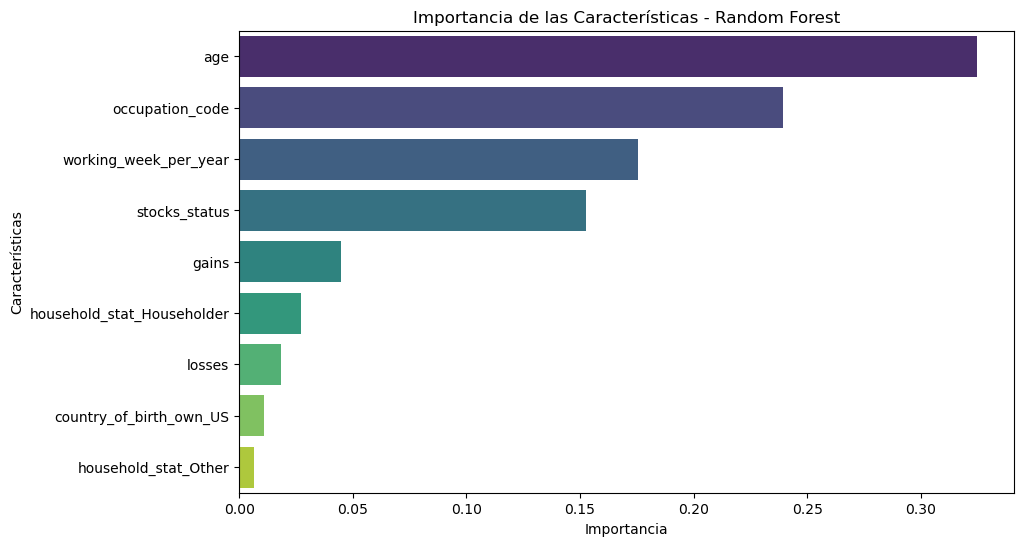

In [105]:
# Obtener la importancia de las características del modelo Random Forest
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train_resampled.columns)

# Seleccionar las 10 más importantes
top_features = feature_importances.nlargest(11)

# Graficar la importancia de las características
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.title("Importancia de las Características - Random Forest")
plt.show()